# core

> Some custom Torchvision tranforms.

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import sys
from typing import Any, Dict, Optional, List, Tuple, Union
import random
from functools import singledispatchmethod

from cjm_pil_utils.core import stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil

import numpy as np

from PIL import Image

# Import PyTorch dependencies
import torch
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision import tv_tensors
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

from torchvision.transforms.v2._utils import query_size, get_bounding_boxes
from torchvision.ops.boxes import box_iou
from torchvision.ops import box_convert
from torchvision.tv_tensors import BoundingBoxFormat
from torchvision.tv_tensors import wrap as tv_wrap
from torchvision.utils import draw_bounding_boxes

Image Dims: (384, 512)


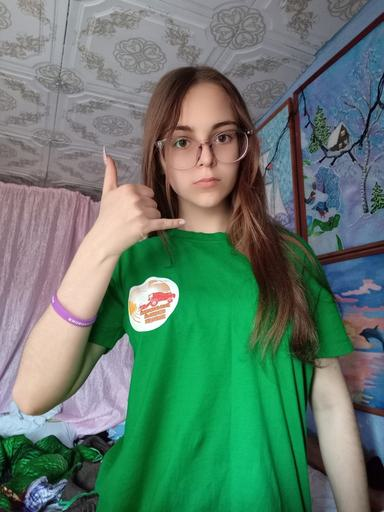

In [ ]:
img_path = './images/call-hand-gesture.png'

# Open the associated image file as a RGB image
sample_img = Image.open(img_path).convert('RGB')

# Print the dimensions of the image
print(f"Image Dims: {sample_img.size}")

# Show the image
sample_img

In [ ]:
#| export
class ResizeMax(transforms.Transform):
    """
    A PyTorch Transform class that resizes an image such that the maximum dimension 
    is equal to a specified size while maintaining the aspect ratio.
    """
    
    def __init__(self, 
                 max_sz:int=256 # The maximum size for any dimension (height or width) of the image.
                ):
        """
        Initialize ResizeMax object with a specified max_sz. 
        """
        # Call to the parent class (Transform) constructor
        super().__init__()

        # Set the maximum size for any dimension of the image
        self.max_sz = max_sz
        
    def _transform(self, 
                   inpt: Any, # The input image tensor to be resized.
                   params: Dict[str, Any] # A dictionary of parameters. Not used in this method but is present for compatibility with the parent's method signature.
                  ) -> torch.Tensor: # The resized image tensor.
        """
        Apply the ResizeMax transformation on an input image tensor.
        """

        # Copy the input tensor to a new variable
        x = inpt

        # Get the width and height of the image tensor
        spatial_size = TF.get_size(x)

        # Calculate the size for the smaller dimension, such that the aspect ratio 
        # of the image is maintained when the larger dimension is resized to max_sz
        size = int(min(spatial_size) / (max(spatial_size) / self.max_sz))

        # Resize the image tensor with antialiasing for smoother output
        x = TF.resize(x, size=size, antialias=True)

        # Return the transformed (resized) image tensor
        return x

In [ ]:
target_sz = 384

Source image: (384, 512)
Image tensor: torch.Size([1, 3, 512, 384])
Padded tensor: torch.Size([1, 3, 384, 288])


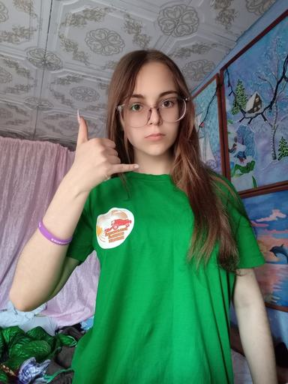

In [ ]:
print(f"Source image: {sample_img.size}")

# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=target_sz)

# Convert the cropped image to a tensor
img_tensor = transforms.PILToTensor()(sample_img)[None]
print(f"Image tensor: {img_tensor.shape}")

# Resize the tensor
resized_tensor = resize_max(img_tensor)
print(f"Padded tensor: {resized_tensor.shape}")

# Display the updated image
tensor_to_pil(resized_tensor)

In [ ]:
#| export
class PadSquare(transforms.Transform):
    """
    PadSquare is a PyTorch Transform class used to pad images to make them square. 
    Depending on the configuration, padding can be applied equally on both sides, 
    or can be randomly split between the two sides.
    """

    def __init__(self, 
                 padding_mode:str='constant', # The method to use for padding. Default is 'constant'.
                 fill:tuple=(123, 117, 104), # The RGB values to use for padding if padding_mode is 'constant'.
                 shift:bool=True # If True, padding is randomly split between the two sides. If False, padding is equally applied.
                ):
        """
        The constructor for PadSquare class.
        """
        super().__init__()
        self.padding_mode = padding_mode
        self.fill = fill
        self.shift = shift
        self.pad_split = None

    def forward(self, 
                *inputs: Any # The inputs to the forward method.
               ) -> Any: # The result of the superclass forward method.
        """
        The forward method that sets up the padding split factor if 'shift' is True, 
        and then calls the superclass forward method.
        """
        self.pad_split = random.random() if self.shift else None
        return super().forward(*inputs)

    def _transform(self, 
                   inpt: Any, # The input to be transformed.
                   params: Dict[str, Any] # A dictionary of parameters for the transformation.
                  ) -> Any: # The transformed input.
        """
        The _transform method that applies padding to the input to make it square.
        """
        x = inpt
        
        # Get the width and height of the image tensor
        h, w = TF.get_size(x)
        
        # If shift is true, padding is randomly split between two sides
        if self.shift:
            offset = (max(w, h) - min(w, h))
            pad_1 = int(offset*self.pad_split)
            pad_2 = offset - pad_1
            
            # The padding is applied to the shorter dimension of the image
            self.padding = [0, pad_1, 0, pad_2] if h < w else [pad_1, 0, pad_2, 0]
            padding = self.padding
        else:
            # If shift is false, padding is equally split between two sides
            offset = (max(w, h) - min(w, h)) // 2
            padding = [0, offset] if h < w else [offset, 0]
        
        # Apply the padding to the image
        x = TF.pad(x, padding=padding, padding_mode=self.padding_mode, fill=self.fill)
        
        return x

Resized tensor: torch.Size([3, 384, 288])
Padded tensor: torch.Size([3, 384, 384])


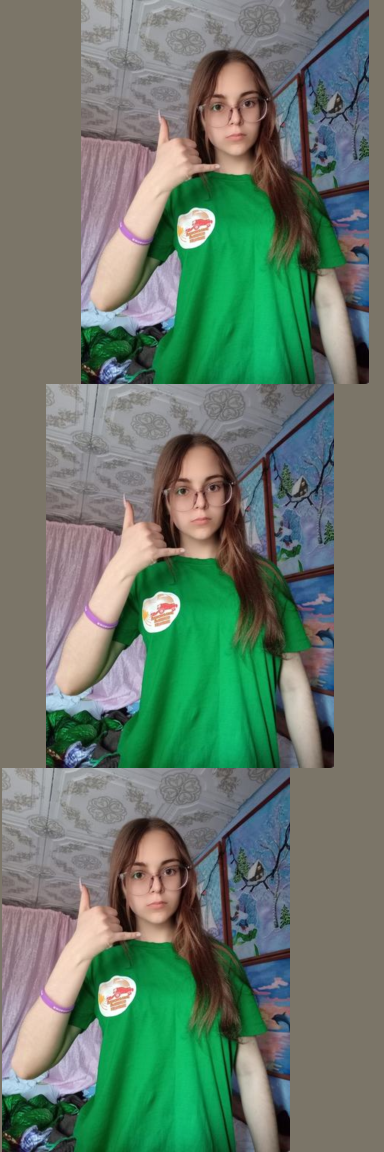

In [ ]:
print(f"Resized tensor: {resized_tensor.shape}")

# Create a `PadSquare` object
pad_square = PadSquare(shift=True)

# Pad the tensor
padded_tensor = pad_square(resized_tensor)
print(f"Padded tensor: {padded_tensor.shape}")

# Display the updated image
stack_imgs([tensor_to_pil(pad_square(resized_tensor)) for i in range(3)])

In [ ]:
#| export
class CustomTrivialAugmentWide(torchvision.transforms.TrivialAugmentWide):
    """
    This class extends the TrivialAugmentWide class provided by PyTorch's transforms module.
    TrivialAugmentWide is an augmentation policy randomly applies a single augmentation to each image.
    """
    def __init__(
        self,
        num_magnitude_bins: int = 31,
        interpolation: transforms.InterpolationMode = transforms.InterpolationMode.NEAREST,
        fill: Optional[List[float]] = None,
        op_meta: Optional[Dict[str, Tuple[torch.Tensor, bool]]] = None
    ) -> None:
        super().__init__(num_magnitude_bins, interpolation, fill)
        self.op_meta = op_meta if op_meta else super()._augmentation_space(num_bins)

    def _augmentation_space(self, 
                            num_bins: int
                           ) -> Dict[str, Tuple[torch.Tensor, bool]]:
        return self.op_meta

In [ ]:
num_bins = 31

custom_augmentation_space = {
    # Identity operation doesn't change the image
    "Identity": (torch.tensor(0.0), False),
            
    # Distort the image along the x or y axis, respectively.
    "ShearX": (torch.linspace(0.0, 0.25, num_bins), True),
    "ShearY": (torch.linspace(0.0, 0.25, num_bins), True),

    # Move the image along the x or y axis, respectively.
    "TranslateX": (torch.linspace(0.0, 32.0, num_bins), True),
    "TranslateY": (torch.linspace(0.0, 32.0, num_bins), True),

    # Rotate operation: rotates the image.
    "Rotate": (torch.linspace(0.0, 45.0, num_bins), True),

    # Adjust brightness, color, contrast,and sharpness respectively.
    "Brightness": (torch.linspace(0.0, 0.75, num_bins), True),
    "Color": (torch.linspace(0.0, 0.99, num_bins), True),
    "Contrast": (torch.linspace(0.0, 0.99, num_bins), True),
    "Sharpness": (torch.linspace(0.0, 0.99, num_bins), True),

    # Reduce the number of bits used to express the color in each channel of the image.
    "Posterize": (8 - (torch.arange(num_bins) / ((num_bins - 1) / 6)).round().int(), False),

    # Invert all pixel values above a threshold.
    "Solarize": (torch.linspace(255.0, 0.0, num_bins), False),

    # Maximize the image contrast by setting the darkest color to black and the lightest to white.
    "AutoContrast": (torch.tensor(0.0), False),

    # Equalize the image histogram to improve its contrast.
    "Equalize": (torch.tensor(0.0), False),
}

Augmented tensor: torch.Size([3, 384, 288])


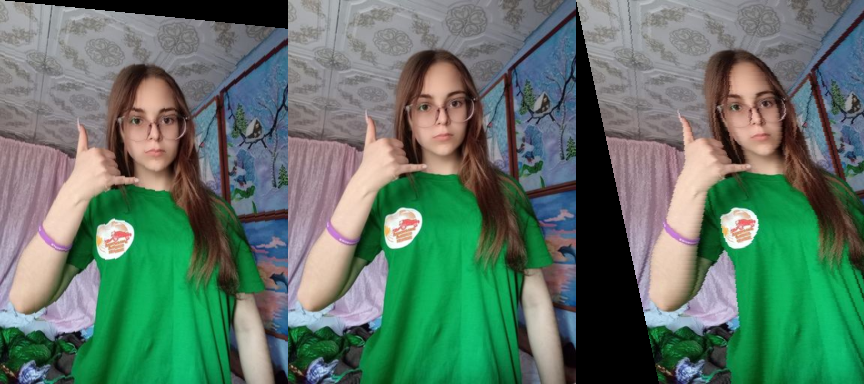

In [ ]:
# Create a `CustomTrivialAugmentWide` object
trivial_aug = CustomTrivialAugmentWide(op_meta=custom_augmentation_space)

# Pad the tensor
aug_tensor = trivial_aug(resized_tensor)
print(f"Augmented tensor: {aug_tensor.shape}")

# Display the updated image
stack_imgs([tensor_to_pil(trivial_aug(resized_tensor)) for i in range(3)])

In [ ]:
#| export
class CustomRandomIoUCrop(transforms.RandomIoUCrop):
    
    """
    A customized Random IoU crop transformation that inherits from torchvision's RandomIoUCrop transform.
    """
    
    def __init__(
        self,
        min_scale: float = 0.3, # Minimum factors to scale the input size.
        max_scale: float = 1.0, # Maximum factors to scale the input size.
        min_aspect_ratio: float = 0.5, # Minimum aspect ratio for the cropped image or video.
        max_aspect_ratio: float = 2.0, # Maximum aspect ratio for the cropped image or video.
        sampler_options: Optional[List[float]] = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0], # List of minimal IoU (Jaccard) overlap between all the boxes a cropped image or video.
        trials: int = 40, # Number of trials to find a crop for a given value of minimal IoU (Jaccard) overlap.
        jitter_factor: float = 0.0 # Value to jitter the center coordinates for the crop area.
    ):
        super().__init__(min_scale, max_scale, min_aspect_ratio, max_aspect_ratio, sampler_options, trials)
        self.jitter_factor = jitter_factor
    
    def _get_params(self, flat_inputs: List[Any]) -> Dict[str, Any]:
        orig_h, orig_w = query_size(flat_inputs)
        bboxes = get_bounding_boxes(flat_inputs)
        
        bbox_dims = bboxes[...,2:]

        # Get all bbox centers
        xyxy_bboxes_orig = box_convert(
            bboxes.as_subclass(torch.Tensor), bboxes.format.value.lower(), torchvision.tv_tensors.BoundingBoxFormat.XYXY.value.lower()
        )

        cx = 0.5 * (xyxy_bboxes_orig[..., 0] + xyxy_bboxes_orig[..., 2])
        cy = 0.5 * (xyxy_bboxes_orig[..., 1] + xyxy_bboxes_orig[..., 3])
        
        for _ in range(self.trials):
            # Sample an option
            idx = int(torch.randint(low=0, high=len(self.options), size=(1,)))
            min_jaccard_overlap = self.options[idx]
            if min_jaccard_overlap >= 1.0:
                return dict()

            # Check aspect ratio limitations and generate new width and height
            while True:
                r = self.min_scale + (self.max_scale - self.min_scale) * torch.rand(2)
                new_w = int(orig_w * r[0])
                new_h = int(orig_h * r[1])
                aspect_ratio = new_w / new_h
                if self.min_aspect_ratio <= aspect_ratio <= self.max_aspect_ratio:
                    break

            # Bounding Box Guided Sampling
            center_idx = torch.randint(low=0, high=cx.shape[0], size=(1,))
            crop_center_x = cx[center_idx]
            crop_center_y = cy[center_idx]
            
            # Add jitter to the crop centers
            jitter_val_x = self.jitter_factor * bbox_dims[center_idx.item()][0].item() * torch.randn(1).to(crop_center_x.device)
            jitter_val_y = self.jitter_factor * bbox_dims[center_idx.item()][1].item() * torch.randn(1).to(crop_center_y.device)

            crop_center_x += jitter_val_x
            crop_center_y += jitter_val_y

            left = int(crop_center_x - new_w / 2)
            top = int(crop_center_y - new_h / 2)
            right = left + new_w
            bottom = top + new_h

            # Adjust if out of bounds
            if left < 0: left, right = 0, new_w
            if right > orig_w: right, left = orig_w, orig_w - new_w
            if top < 0: top, bottom = 0, new_h
            if bottom > orig_h: bottom, top = orig_h, orig_h - new_h

            is_within_crop_area = (left < cx) & (cx < right) & (top < cy) & (cy < bottom)
            if not is_within_crop_area.any():
                continue

            # Check at least 1 box with jaccard limitations
            xyxy_bboxes = xyxy_bboxes_orig[is_within_crop_area]
            ious = box_iou(
                xyxy_bboxes,
                torch.tensor([[left, top, right, bottom]], dtype=xyxy_bboxes.dtype, device=xyxy_bboxes.device),
            )
                        
            if ious.max() < min_jaccard_overlap:
                continue
            
            return dict(top=top, 
                        left=left, 
                        height=new_h, 
                        width=new_w, 
                        is_within_crop_area=is_within_crop_area)
        return dict()

In [ ]:
class_names = ['call']

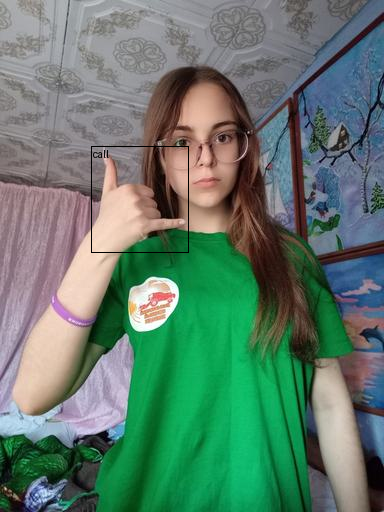

In [ ]:
# Prepare bounding box targets
targets = {
    'boxes': BoundingBoxes([[ 91.8727, 146.4079, 188.0844, 252.7894]], 
                         format=BoundingBoxFormat.XYXY, 
                         canvas_size=sample_img.size[::-1]),
    'labels': torch.Tensor([class_names.index(label) for label in ['call']])
}
# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bounding_boxes(
    image=transforms.PILToTensor()(sample_img), 
    boxes=targets['boxes'], 
    labels=[class_names[int(label.item())] for label in targets['labels']],
)

display(tensor_to_pil(annotated_tensor))

In [ ]:
#| hide
torch.manual_seed(1);

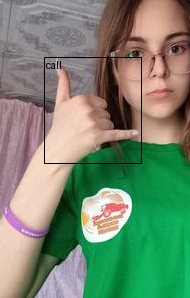

In [ ]:
# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3, 
                                  max_scale=1.0, 
                                  min_aspect_ratio=0.5, 
                                  max_aspect_ratio=2.0, 
                                  sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                                  trials=400, 
                                  jitter_factor=0.25)

# Crop the image
cropped_img, cropped_targets = iou_crop(sample_img, targets)
sanitized_img, sanitized_targets = transforms.SanitizeBoundingBoxes()(cropped_img, cropped_targets)

# Annotate the augmented image with updated labels and bounding boxes
annotated_tensor = draw_bounding_boxes(
    image=transforms.PILToTensor()(sanitized_img), 
    boxes=cropped_targets['boxes'], 
    labels=[class_names[int(label.item())] for label in sanitized_targets['labels']],
)

tensor_to_pil(annotated_tensor)

In [ ]:
#| export
class RandomPatchCopy(transforms.Transform):
    """
    A torchvision V2 transform that copies data from a randomly selected rectangular patch
    to another randomly selected rectangular region of an image tensor multiple times.
    """
    def __init__(self, 
                 pct:float=0.2, # The percentage of the tensor's size to be used as the side length of the square regions.
                 min_num:int=0, # The minimum number of times to apply the `rand_square_copy` function.
                 max_num:int=4, # The maximum number of times to apply the `rand_square_copy` function.
                 iou_thresh:float=0.25 # The IoU threshold for bounding box suppression.
                ):
        
        super().__init__()
        self.pct = pct
        self.min_num = min_num
        self.max_num = max_num
        self.iou_thresh = iou_thresh
        self.patches = []


    def calculate_iou_multi(self,
                            boxes1:torch.Tensor, # An array of bounding boxes in [x1, y1, x2, y2] format.
                            boxes2:torch.Tensor # Another array of bounding boxes in [x1, y1, x2, y2] format.
                           ) -> torch.Tensor: # A 2D array where element (i, j) is the IoU of boxes1[i] and boxes2[j].
        """
        Calculate the Intersection over Union (IoU) for each combination of bounding boxes in two arrays
        using PyTorch broadcasting.
        """
        # Expand boxes1 and boxes2 for broadcasting
        boxes1 = boxes1[:, None, :]
        boxes2 = boxes2[None, :, :]
    
        # Calculate intersection coordinates
        int_x1 = torch.max(boxes1[..., 0], boxes2[..., 0])
        int_y1 = torch.max(boxes1[..., 1], boxes2[..., 1])
        int_x2 = torch.min(boxes1[..., 2], boxes2[..., 2])
        int_y2 = torch.min(boxes1[..., 3], boxes2[..., 3])
    
        # Calculate intersection and union areas
        int_area = torch.clamp(int_x2 - int_x1, min=0) * torch.clamp(int_y2 - int_y1, min=0)
        box1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
        box2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])
        union_area = box1_area + box2_area - int_area
    
        # Calculate IoU
        iou = int_area / torch.clamp(union_area, min=1e-10)
    
        return iou
    

    def rand_patch_copy(self, 
                        img_tensor:torch.Tensor, # The input image tensor.
                        pct:float # # The percentage of the image tensor's size to be used as the side length of the patch.
                       ) -> (torch.Tensor, tuple): # The modified input image tensor and coordinates of the target patch in the format [x, y, w, h].
        """
        Copy data from a randomly selected rectangular patch to another randomly selected 
        rectangular region of an image tensor, and return the coordinates of the target patch.
        Assumes the tensor is in 'channels-first' format.
        """
        if not (0 < pct <= 1):
            raise ValueError("pct must be between 0 and 1")
    
        # Get the shape of the tensor
        _, h, w = img_tensor.shape
    
        # Calculate the size of the rectangle
        szx = int(pct * w)
        szy = int(pct * h)
    
        # Calculate the top-left coordinate of the source rectangle
        sty1 = random.randint(0, w - szx)  # x-coordinate
        stx1 = random.randint(0, h - szy)  # y-coordinate
    
        # Calculate the top-left coordinate of the target rectangle
        sty2 = random.randint(0, w - szx)  # x-coordinate
        stx2 = random.randint(0, h - szy)  # y-coordinate
    
        # Copy the data from the source square to the target rectangle
        img_tensor[:, stx2:stx2 + szy, sty2:sty2 + szx] = img_tensor[:, stx1:stx1 + szy, sty1:sty1 + szx]
    
        # The coordinates of the target patch
        target_patch_coords = [sty2, stx2, sty2 + szx, stx2 + szy]
    
        return img_tensor, target_patch_coords


    @singledispatchmethod
    def _transform(self, inpt: Any, params: Dict[str, Any]) -> Any:
        """Default Behavior: Don't modify the input"""
        return inpt

    @_transform.register(torch.Tensor)
    @_transform.register(tv_tensors.Image)
    def _(self, inpt: Union[torch.Tensor, tv_tensors.Image], params: Dict[str, Any]) -> Any:
        self.patches = []
        """Apply the `rand_square_copy` function to the input tensor multiple times"""
        for i in range(random.randint(self.min_num, self.max_num)):
            inpt, patch = self.rand_patch_copy(inpt, max(0.1,random.random()*self.pct))
            self.patches.append(patch)
        return inpt

    @_transform.register(Image.Image)
    def _(self, inpt: Image.Image, params: Dict[str, Any]) -> Any:
        """Convert the PIL Image to a torch.Tensor to apply the transform"""
        inpt_torch = transforms.PILToTensor()(inpt)    
        return transforms.ToPILImage()(self._transform(inpt_torch, params))
    
    @_transform.register(BoundingBoxes)
    def _(self, inpt: BoundingBoxes, params: Dict[str, Any]) -> Any:
        """Update the bounding box annotations based on the list of patches"""
        if len(self.patches) > 0:
            iou_matrix = self.calculate_iou_multi(inpt, torch.tensor(self.patches, dtype=torch.float32))
            
            # Sum the IoU values for each box in boxes1
            cumulative_iou = torch.sum(iou_matrix, axis=1)
            # Create a mask based on the cumulative IoU threshold
            mask = cumulative_iou > self.iou_thresh
            inpt_copy = torch.clone(inpt)
            inpt_copy[mask] = 0
            return tv_wrap(inpt_copy, like=inpt)
        return inpt

    @_transform.register(Mask)
    def _(self, inpt: Mask, params: Dict[str, Any]) -> Any:
        """Don't modify segmentation annotations"""
        return inpt

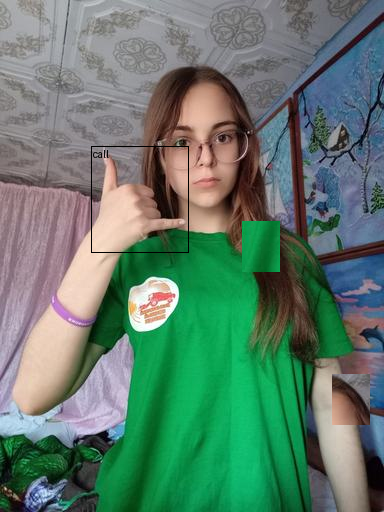

In [ ]:
# Create a RandomPatchCopy object
rand_patch_copy_tfm = RandomPatchCopy(pct=0.3, min_num=1, max_num=4)

# Feed sample image and targets through the image transform
augmented_img, augmented_targets = rand_patch_copy_tfm(sample_img, targets)
# Remove degenerate/invalid bounding boxes and their corresponding labels and masks.
sanitized_img, sanitized_targets = transforms.SanitizeBoundingBoxes()(augmented_img, augmented_targets)

# Annotate the augmented image with updated labels and bounding boxes
annotated_tensor = draw_bounding_boxes(
    image=transforms.PILToTensor()(sanitized_img), 
    boxes=sanitized_targets['boxes'], 
    labels=[class_names[int(label.item())] for label in sanitized_targets['labels']], 
)

# Display the augmented image
tensor_to_pil(annotated_tensor)

In [ ]:
#| export
class RandomPixelCopy(transforms.Transform):
    """
    A torchvision V2 transform that copies data from a randomly selected set of pixels to another 
    randomly selected set of pixels of a image tensor.
    """
    def __init__(self,
                 min_pct=0.0025, # The minimum percentage of the tensor's pixels to be copied.
                 max_pct:float=0.1 # The maximum percentage of the tensor's pixels to be copied.
                ):
        
        super().__init__()
        self.min_pct = min_pct
        self.max_pct = max_pct

    def rand_pixel_copy(self, 
                        img_tensor:torch.Tensor, # The input image tensor.
                        pct:float # The percentage of the total number of pixels to be selected as the source and target sets of pixels.
                       ) -> torch.Tensor : # The modified input image tensor.
        """
        Copy data from a randomly selected set of pixels to another randomly selected set of pixels of a image tensor.
        """
        
        src_dim = img_tensor.dim()
        
        img_tensor = img_tensor.unsqueeze(0) if src_dim == 3 else img_tensor
        
        # Get the shape of the img_tensor
        b, c, h, w = img_tensor.shape
        
        # Calculate the number of pixels to be selected
        num_pixels = int(img_tensor[-1:].numel() * pct)
        
        # Select the source pixel indices
        source_indices = torch.LongTensor(num_pixels, 2).random_(0, h * w)
        source_indices[:, 0] = source_indices[:, 0] // w
        source_indices[:, 1] = source_indices[:, 1] % w
        
        # Select the target pixel indices
        target_indices = torch.LongTensor(num_pixels, 2).random_(0, h * w)
        target_indices[:, 0] = target_indices[:, 0] // w
        target_indices[:, 1] = target_indices[:, 1] % w
        
        # Get the indices of the channels
        c_indices = torch.arange(c).repeat(num_pixels, 1).t()
        
        # Copy the pixels
        source_pixels = img_tensor[:, c_indices, source_indices[:, 0], source_indices[:, 1]]
        img_tensor[:, c_indices, target_indices[:, 0], target_indices[:, 1]] = source_pixels
        
        return img_tensor.squeeze(0) if src_dim == 3 else img_tensor

    @singledispatchmethod
    def _transform(self, inpt: Any, params: Dict[str, Any]) -> Any:
        """Default Behavior: Don't modify the input"""
        return inpt

    @_transform.register(torch.Tensor)
    @_transform.register(tv_tensors.Image)
    def _(self, inpt: Union[torch.Tensor, tv_tensors.Image], params: Dict[str, Any]) -> Any:
        """Apply the `rand_pixel_copy` method to the input tensor"""
        return self.rand_pixel_copy(inpt, max(self.min_pct, random.random() * self.max_pct))

    @_transform.register(Image.Image)
    def _(self, inpt: Image.Image, params: Dict[str, Any]) -> Any:
        """Convert the PIL Image to a torch.Tensor to apply the transform"""
        inpt_torch = transforms.PILToTensor()(inpt)
        return transforms.ToPILImage()(self._transform(inpt_torch, params))

    @_transform.register(BoundingBoxes)
    @_transform.register(Mask)
    def _(self, inpt: Union[BoundingBoxes, Mask], params: Dict[str, Any]) -> Any:
        """Don't modify image annotations"""
        return inpt

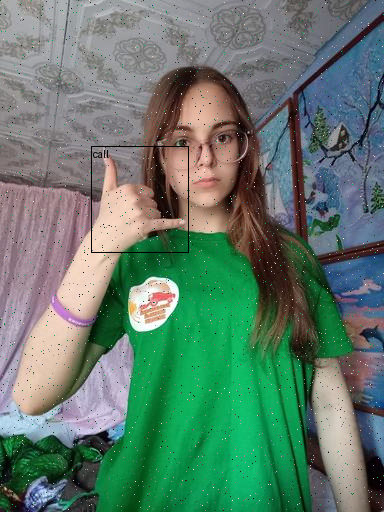

In [ ]:
# Create a RandomPixelCopy object
rand_pixel_copy_tfm = RandomPixelCopy(max_pct=0.05)

# Feed sample image and targets through the image transform
augmented_img, augmented_targets = rand_pixel_copy_tfm(sample_img, targets)

# Annotate the augmented image with updated labels and bounding boxes
annotated_tensor = draw_bounding_boxes(
    image=transforms.PILToTensor()(augmented_img), 
    boxes=augmented_targets['boxes'], 
    labels=[class_names[int(label.item())] for label in augmented_targets['labels']], 
)

# Display the augmented image
transforms.ToPILImage()(annotated_tensor)

In [ ]:
#| export
class CustomRandomAugment(torch.nn.Module):
    """
    A PyTorch Module for applying a random augmentation from a predefined set of augmentations
    to an image and its associated targets (e.g., bounding boxes, masks). This class is designed
    to work with torchvision transforms and supports augmentation of both images and their
    corresponding target data.
    """

    def __init__(self, 
                 num_bins:int=31, # The number of discrete levels for certain augmentations.
                 shear:int=18, # Maximum shear angle for the RandomAffine transform.
                 translate:float=0.25, # Maximum translation as a fraction of image dimensions for RandomAffine.
                 degrees:float=70.0, # Range of degrees for random rotations.
                 brightness:float=0.75, # Brightness adjustment factor.
                 hue:float=0.4, # Hue adjustment range.
                 saturation:float=0.99, # Saturation adjustment factor.
                 contrast:float=0.75, # Contrast adjustment factor.
                 sharpness:tuple=(0.0, 1.99), # Range for sharpness factor adjustments.
                 posterize:tuple=(2.0, 8.0), # Range for bits in posterization.
                 solarize:tuple=(1.0, 255.0) #  Threshold range for solarization.
                ):
        """
        Initializes the CustomRandomAugment object with specific parameters for augmentations.
        """
        # Initialize the parent class (torch.nn.Module)
        super().__init__()

        # Number of bins for discretizing continuous parameters of augmentations
        self.num_bins = num_bins

        # Create lists of transformations for sharpness, posterization, and solarization
        # with granularity defined by num_bins
        self.random_sharpness_tfms = [transforms.RandomAdjustSharpness(sharpness_factor=x, p=1.0) 
                                      for x in torch.linspace(*sharpness, num_bins)]
        self.random_posterize_tfms = [transforms.RandomPosterize(bits=x, p=1.0) 
                                      for x in torch.linspace(*posterize, num_bins).floor().int().numpy()]
        self.random_solarize_tfms = [transforms.RandomSolarize(threshold=x, p=1.0) 
                                     for x in torch.linspace(*solarize, num_bins)]

        # Compose a transform that randomly selects from the list of transformations including
        # identity (no-op), affine transforms, rotations, color jitters, sharpness, posterize,
        # solarize, autocontrast, equalize, and Gaussian blur.
        self.transforms = transforms.RandomChoice([
            transforms.Identity(),  # No-op, to sometimes leave images unchanged
            transforms.RandomAffine(degrees=0.0, shear=shear),  # Random shear
            transforms.RandomAffine(degrees=0.0, translate=(translate, translate)),  # Random translation
            transforms.RandomRotation(degrees=degrees),  # Random rotation
            transforms.ColorJitter(brightness=brightness),  # Adjust brightness
            transforms.ColorJitter(hue=(-hue, hue)),  # Adjust hue
            transforms.ColorJitter(saturation=saturation),  # Adjust saturation
            transforms.ColorJitter(contrast=contrast),  # Adjust contrast
            transforms.RandomChoice(self.random_sharpness_tfms),  # Random sharpness
            transforms.RandomChoice(self.random_posterize_tfms),  # Random posterize
            transforms.RandomChoice(self.random_solarize_tfms),  # Random solarize
            transforms.RandomAutocontrast(p=1.0),  # Random autocontrast
            transforms.RandomEqualize(p=1.0),  # Random equalize
        ])
    
    def forward(self, img, targets=None):
        """
        Applies a random augmentation to the input image and targets.

        Parameters:
            img (Tensor): The input image tensor.
            targets: The associated targets (e.g., bounding boxes, masks) with the image.

        Returns:
            A tuple containing the augmented image and targets.
        """
        # Apply the composed transformations to the image and targets
        return self.transforms(img, targets)

In [ ]:
#| hide
torch.manual_seed(14);

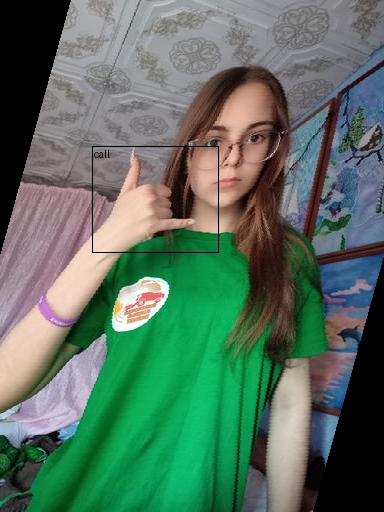

In [ ]:
# Create a RandomIoUCrop object
random_aug_tfm = CustomRandomAugment()

# Augment the image
augmented_img, augmented_targets = random_aug_tfm(sample_img, targets)
sanitized_img, sanitized_targets = transforms.SanitizeBoundingBoxes()(augmented_img, augmented_targets)

# Annotate the augmented image with updated labels and bounding boxes
annotated_tensor = draw_bounding_boxes(
    image=transforms.PILToTensor()(sanitized_img), 
    boxes=sanitized_targets['boxes'], 
    labels=[class_names[int(label.item())] for label in sanitized_targets['labels']],
)

tensor_to_pil(annotated_tensor)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()